# Introduction

In this lab, we will explore text vectorization, which is the process of representing non-numerical input data (such as dictionaries or text documents) as vectors of real numbers. We will compare two methods, **FeatureHasher** and **DictVectorizer**, by using both methods to vectorize text documents that are preprocessed (tokenized) with the help of a custom Python function.

# Load Data

We will load data from **20newsgroups_dataset**, which comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training and one for testing. For the sake of simplicity and reducing the computational cost, we select a subset of 7 topics and use the training set only.

In [1]:
from sklearn.datasets import fetch_20newsgroups

categories = [
    "alt.atheism",
    "comp.graphics",
    "comp.sys.ibm.pc.hardware",
    "misc.forsale",
    "rec.autos",
    "sci.space",
    "talk.religion.misc",
]

print("Loading 20 newsgroups training data")
raw_data, _ = fetch_20newsgroups(subset="train", categories=categories, return_X_y=True)
data_size_mb = sum(len(s.encode("utf-8")) for s in raw_data) / 1e6
print(f"{len(raw_data)} documents - {data_size_mb:.3f}MB")

Loading 20 newsgroups training data
3803 documents - 6.245MB


# Define preprocessing functions

A token may be a word, part of a word or anything comprised between spaces or symbols in a string. Here we define a function that extracts the tokens using a simple regular expression (regex) that matches Unicode word characters. This includes most characters that can be part of a word in any language, as well as numbers and the underscore:

In [2]:
import re

def tokenize(doc):
    """Extract tokens from doc.

    This uses a simple regex that matches word characters to break strings
    into tokens. For a more principled approach, see CountVectorizer or
    TfidfVectorizer.
    """
    return (tok.lower() for tok in re.findall(r"\w+", doc))

We define an additional function that counts the (frequency of) occurrence of each token in a given document. It returns a frequency dictionary to be used by the vectorizers.

In [3]:
from collections import defaultdict

def token_freqs(doc):
    """Extract a dict mapping tokens from doc to their occurrences."""

    freq = defaultdict(int)
    for tok in tokenize(doc):
        freq[tok] += 1
    return freq

# DictVectorizer

We will benchmark the **DictVectorizer**, which is a method that receives dictionaries as input.

In [4]:
from sklearn.feature_extraction import DictVectorizer
from time import time

t0 = time()
vectorizer = DictVectorizer()
vectorizer.fit_transform(token_freqs(d) for d in raw_data)
duration = time() - t0
print(f"done in {duration:.3f} s")
print(f"Found {len(vectorizer.get_feature_names_out())} unique terms")

done in 0.659 s
Found 47928 unique terms


# FeatureHasher

We will benchmark the **FeatureHasher**, which is a method that builds a vector of pre-defined length by applying a hash function to the features (e.g., tokens), then using the hash values directly as feature indices and updating the resulting vector at those indices.

In [5]:
from sklearn.feature_extraction import FeatureHasher
import numpy as np

t0 = time()
hasher = FeatureHasher(n_features=2**18)
X = hasher.transform(token_freqs(d) for d in raw_data)
duration = time() - t0
print(f"done in {duration:.3f} s")
print(f"Found {len(np.unique(X.nonzero()[1]))} unique tokens")

done in 0.304 s
Found 43873 unique tokens


# Comparison with special purpose text vectorizers

We will compare the previous methods with the **CountVectorizer** and **HashingVectorizer**.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer

t0 = time()
vectorizer = CountVectorizer()
vectorizer.fit_transform(raw_data)
duration = time() - t0
print(f"done in {duration:.3f} s")
print(f"Found {len(vectorizer.get_feature_names_out())} unique terms")

t0 = time()
vectorizer = HashingVectorizer(n_features=2**18)
vectorizer.fit_transform(raw_data)
duration = time() - t0
print(f"done in {duration:.3f} s")

t0 = time()
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(raw_data)
duration = time() - t0
print(f"done in {duration:.3f} s")
print(f"Found {len(vectorizer.get_feature_names_out())} unique terms")

done in 0.440 s
Found 47885 unique terms
done in 0.263 s
done in 0.316 s
Found 47885 unique terms


# Plot the results

We will plot the speed of the above methods for vectorizing.

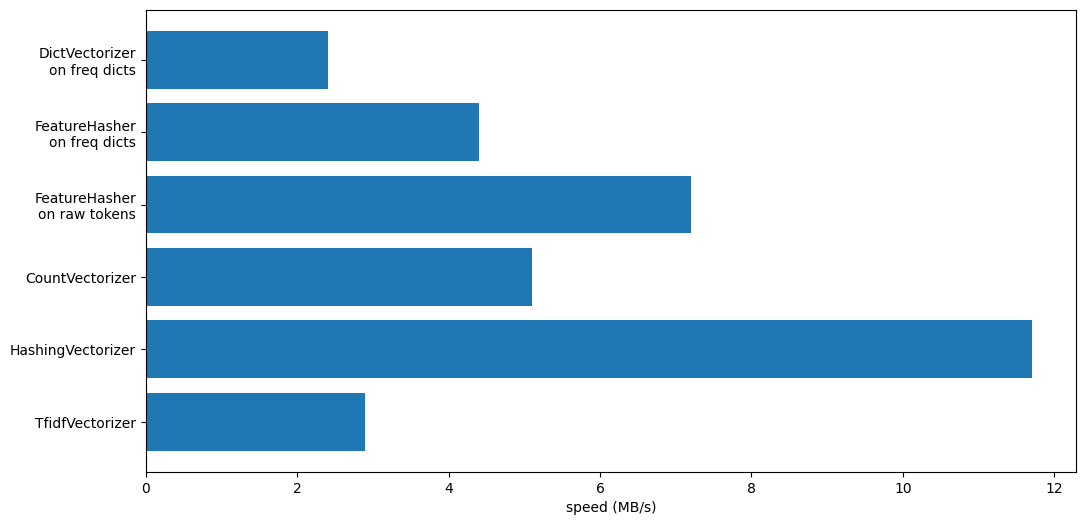

In [7]:
import matplotlib.pyplot as plt

dict_count_vectorizers = {
    "vectorizer": [
        "DictVectorizer\non freq dicts",
        "FeatureHasher\non freq dicts",
        "FeatureHasher\non raw tokens",
        "CountVectorizer",
        "HashingVectorizer",
        "TfidfVectorizer"
    ],
    "speed": [
        2.4, 4.4, 7.2, 5.1, 11.7, 2.9
    ]
}

fig, ax = plt.subplots(figsize=(12, 6))

y_pos = np.arange(len(dict_count_vectorizers["vectorizer"]))
ax.barh(y_pos, dict_count_vectorizers["speed"], align="center")
ax.set_yticks(y_pos)
ax.set_yticklabels(dict_count_vectorizers["vectorizer"])
ax.invert_yaxis()
_ = ax.set_xlabel("speed (MB/s)")

# Summary

In this lab, we explored text vectorization by comparing two methods, **FeatureHasher** and **DictVectorizer**, and four special purpose text vectorizers, **CountVectorizer**, **HashingVectorizer**, and **TfidfVectorizer**. We benchmarked the methods for vectorizing and plotted the results. We concluded that **HashingVectorizer** performs better than **CountVectorizer** at the expense of inversibility of the transformation due to hash collisions. Additionally, **DictVectorizer** and **FeatureHasher** perform better than their equivalent text vectorizers on manually tokenized documents since the internal tokenization step of the former vectorizers compiles a regular expression once and then reuses it for all the documents.